# BST281 Final Project Pipeline

Group 2  
Dongyuan Song, Siquan Wang, Xutao Wang, Linying Zhang

## Set Up
Import packages; set working direcotries.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = 'Arial'
import warnings
warnings.filterwarnings("ignore")
import urllib3
urllib3.disable_warnings()
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from IPython.display import FileLinks
from IPython.display import FileLink
import IPython
from IPython.display import Image

In [5]:
current_path = os.getcwd()
print(current_path)

C:\Users\songdongyuan\group02_final_project_packet


Set working directory. Default is this package folder.

In [6]:
os.chdir(current_path)

Enable using R in Jupyter notebook.

In [7]:
%load_ext rpy2.ipython

Function for displaying Bash code

In [8]:
def highlight_source_bash(filename):
    """For use inside an IPython notebook: given a filename, print the source code. Bash version."""

    from pygments import highlight
    from pygments.lexers import BashLexer
    from pygments.formatters import HtmlFormatter
    from IPython.core.display import HTML

    with open (filename, "r") as myfile:
        data = myfile.read()

    return HTML(highlight(data, BashLexer(), HtmlFormatter(full=True)))

Function for displaying R code

In [9]:
def highlight_source_r(filename):
    """For use inside an IPython notebook: given a filename, print the source code. R version."""

    from pygments import highlight
    from pygments.lexers import SLexer
    from pygments.formatters import HtmlFormatter
    from IPython.core.display import HTML

    with open (filename, "r", encoding="utf8") as myfile:
        data = myfile.read()

    return HTML(highlight(data, SLexer(), HtmlFormatter(full=True)))

## Workflow

This figure shows the overall workflow.

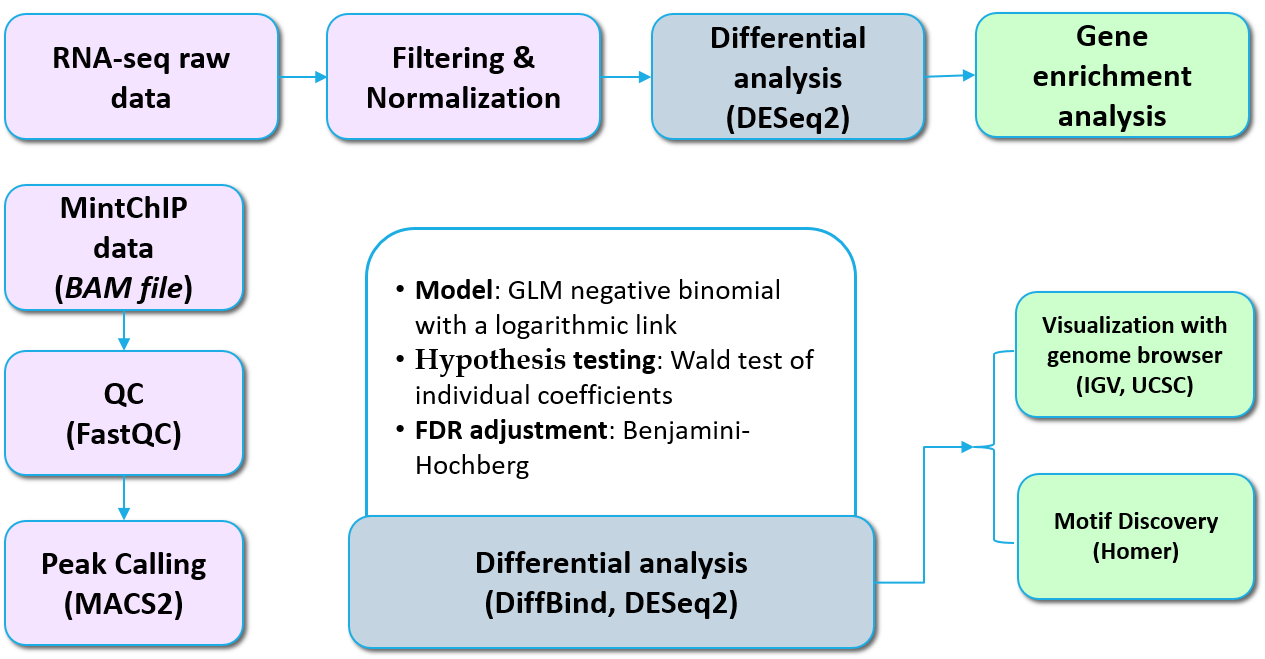

In [16]:
Image("workflow.png", width=600)

## RNA-seq analysis

### Check raw data

In [ ]:
expr_df = pd.read_csv("expressionFile_counts_MM.csv")

In [ ]:
expr_df = expr_df.set_index(expr_df.columns[0])
expr_df.head()

### Quality Control
Filter out none or low expressed genes.

In [ ]:
print(expr_df.shape)

Here we only keep genes which counts are larger than 1 in each samples.

In [ ]:
mask_low_vals = (expr_df > 0).sum(axis=1) == 6
expr_df = expr_df.loc[mask_low_vals, :]
print(expr_df.shape)

Save the result in working directory.

In [ ]:
expr_df.to_csv('filtered.tsv',sep='\t')

### Normalization and Differential Expression Analysis

This step was finished in R. Use Bioconductor Package *edgeR*, *limma* and *DEseq2*.

In [ ]:
!Rscript RNA_seq.R

The codes are showed below.

In [ ]:
highlight_source_r("RNA_seq.R")

The MA plots show that normalization is successful.

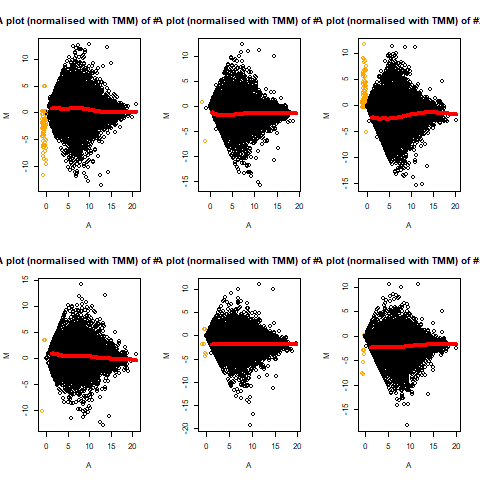

In [12]:
Image("MA plot (normalised with TMM).png")

Also the box plot.

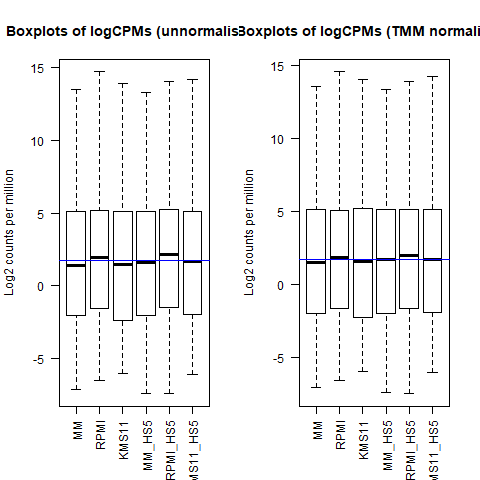

In [13]:
Image("Boxplots of logCPMs.png")

Since here almost all differential expressed genes were up regulated, we only do functional analysis on them.

In [8]:
rna_de = pd.read_csv("DEgene_list.tsv", header=None)

In [9]:
rna_de.head()

,0
0,ABI3BP
1,ABLIM3
2,ACKR3
3,ADAM12
4,ADAMTS1


**Notice** *DESeq2* can automatically finish all pre-processing steps. Therefore, we perfrom the above procedures again and get following results.

Heatmap before DE analysis

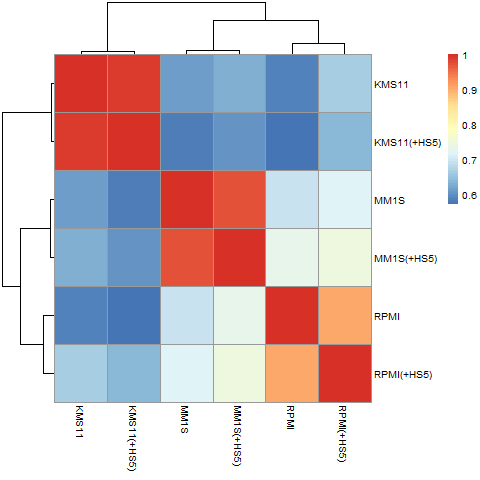

In [10]:
Image('heatmap2.png')

Heatmap after DE analysis.

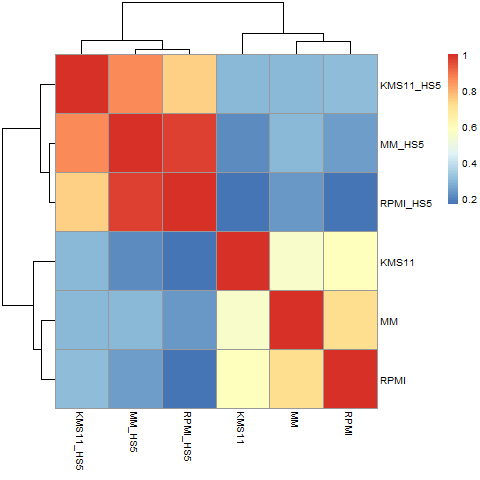

In [11]:
Image("heatmap3.png")

### Enrichment analysis

Use **David** <https://david.ncifcrf.gov/> to perform online enrichment analysis. See the result of KEGG and Biological Process below.

In [ ]:
rna_KEGG = pd.read_csv("RNA_seq_David_KEGG.txt", sep='\t')

In [ ]:
rna_KEGG.head()

In [ ]:
rna_BP = pd.read_csv("RNA_seq_David_BP.txt", sep='\t')
rna_BP.head()

## Mint-ChIP analysis

### Quality Control

The input Mint-ChIP files are BAM file already. Use **fastqc** to do quality control. Computation was done on clusters

In [ ]:
%%bash
sbatch fastqc.sh

The codes are showed below.

In [ ]:
highlight_source_bash("fastqc.sh")

Show the fastqc reports.

In [ ]:
FileLinks(os.path.join('./fastqc_output'), included_suffixes=['.html'])

The reports show that the quality is fine. Use the BAM file for next step.

### Peak Calling

Use MACS2 to do peak calling. Notice some parameters: file type is BAMPE, q = 0.01. Cimputation was done on clusters.

In [ ]:
%%bash
sbatch MACS2.sh

The codes are showed below.

In [ ]:
highlight_source_bash("MACS2.sh")

The peak calling results are showed below.

In [ ]:
FileLinks(os.path.join('./macs2_output'), included_suffixes=['.xls'])

### Differential Binding Analysis
#### Obtaining differetntially bound sites for H3K4me3
#### Read in peakset data
#### Counting reads
We calculate a binding matrix with scores based on read counts for every sample(aﬃnityscores), rather than conﬁdence scores for only those peaks called in a speciﬁc sample(occupancy scores). These reads are otained using the dba.count function. We keeps the peaks at a consistent width, where the peaks will be 500bp, extending 250bp up- and down- stream of the summit.
We then plot the correlation heatmap based on the affinity score

In [ ]:
!Rscript MintChIP.R

The codes are shown below:

In [21]:
highlight_source_r("MintChIP.R")

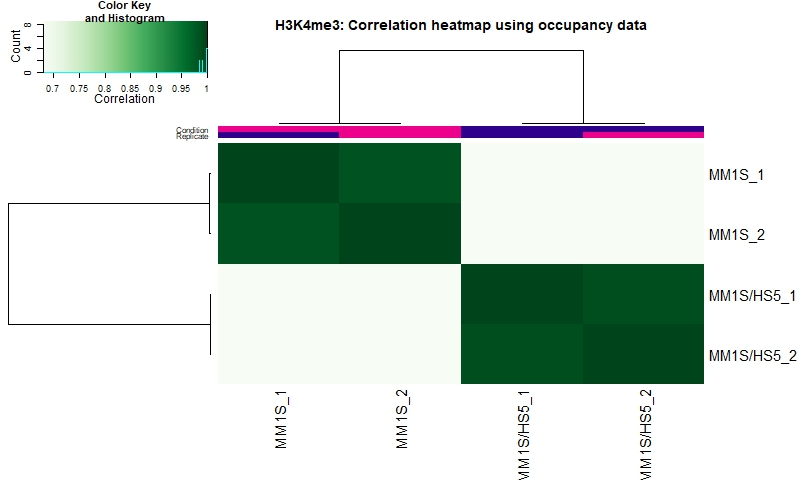

In [22]:
Image(filename='H3K4me3_heat_ocu.jpeg')

#### Establishing contrast
#### Performing the differential analysis
This will run an DESeq2 analysis using the default binding matrix to identify significantly differentially bound sites using the default threshold of FDR <= 0.05

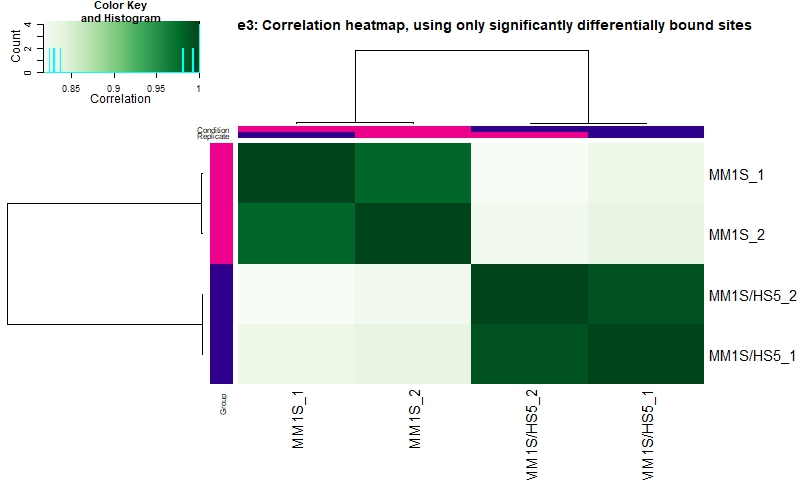

In [23]:
Image(filename='H3K4me3_heat_DB.jpeg')

 ##### Binding afﬁnity heatmap showing afﬁnities for differentially bound sites:

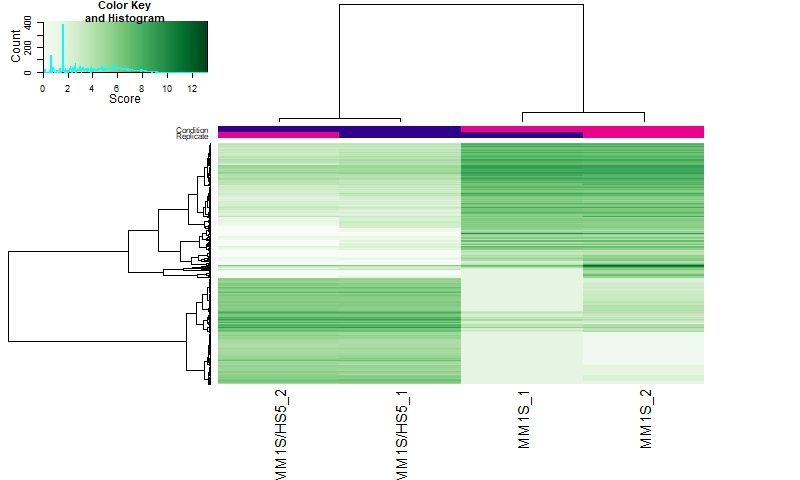

In [24]:
Image(filename='H3K4me3_heat_affinity.jpeg')

 ##### Box plots of read distributions for signiﬁcantly differentially bound (DB) sites :

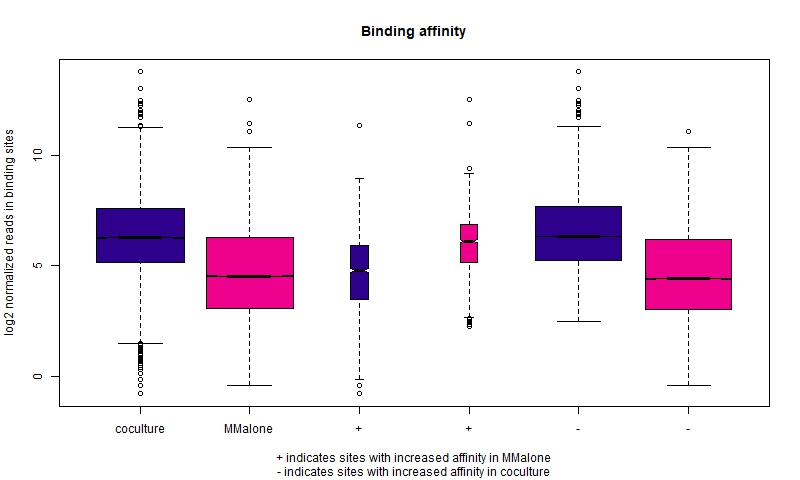

In [25]:
Image(filename='H3K4me3_boxplot.jpeg')

##### MA plot of monoculture co-culture contrast:
Sites identiﬁed as signiﬁcantly diﬀerentially bound shown in red

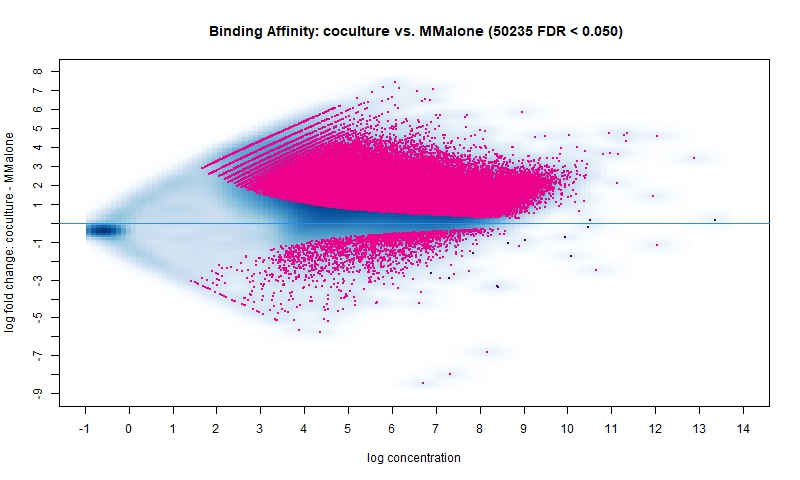

In [26]:
Image(filename='H3K4me3_MA.jpeg')

##### Volcano plot of  monoculture co-culture contrast: 
Sites identiﬁed as signiﬁcantly diﬀerentially bound shown in red

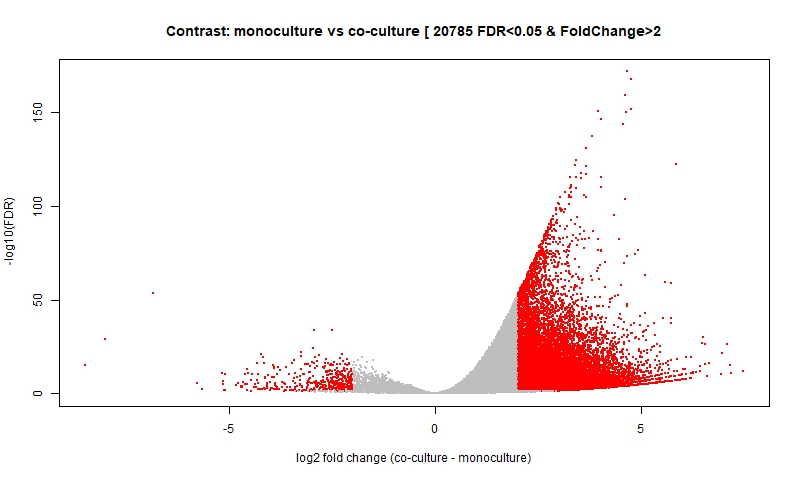

In [27]:
Image(filename='H3K4me3_volcano.jpeg')

#### Retrieving the differentially bound sites

#### Same procedure for H3K27ac

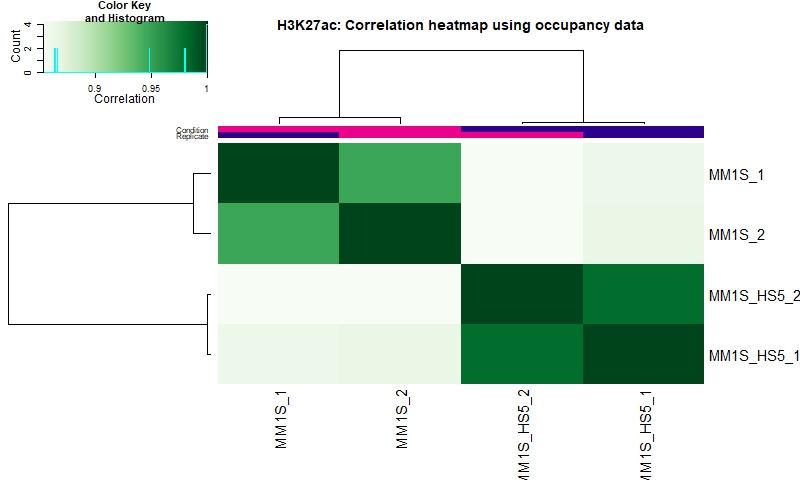

In [28]:
Image(filename='H3K27ac_heat_ocu.jpeg')

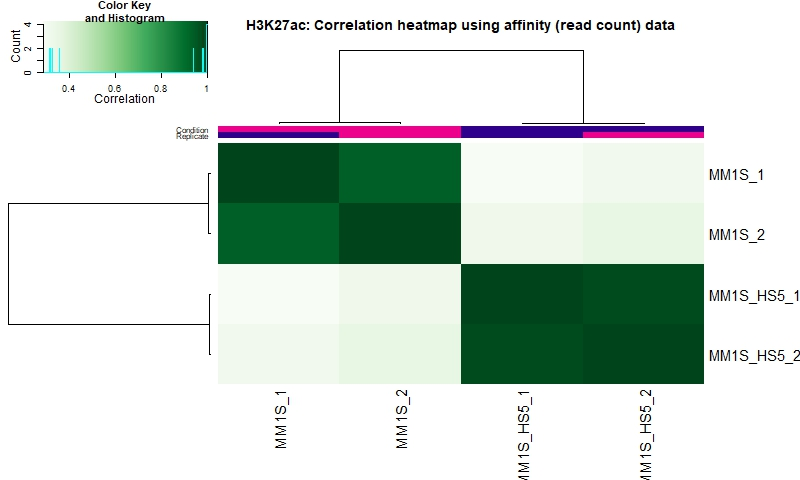

In [29]:
Image(filename='H3K27ac_heat_DB.jpeg')

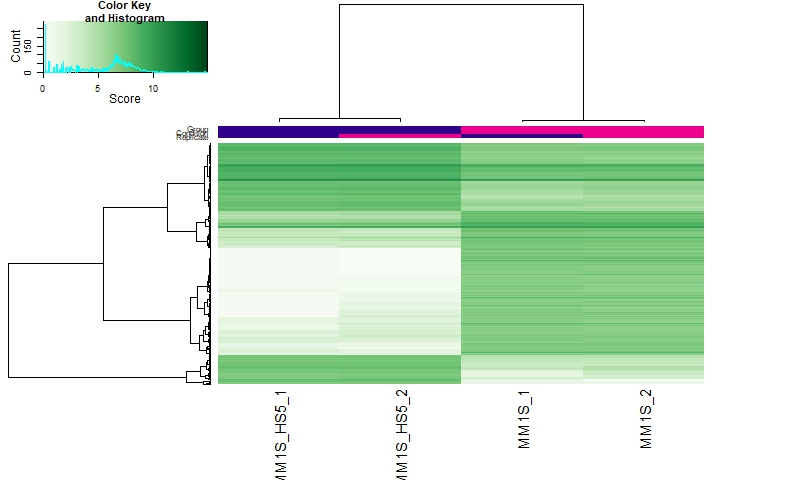

In [30]:
Image(filename='H3K27ac_heat_affinity.jpeg')

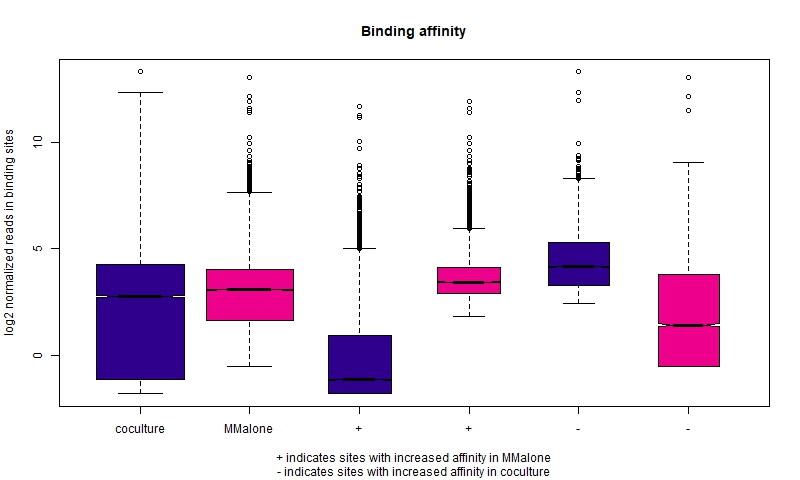

In [31]:
Image('H3K27ac_boxplot.jpeg')

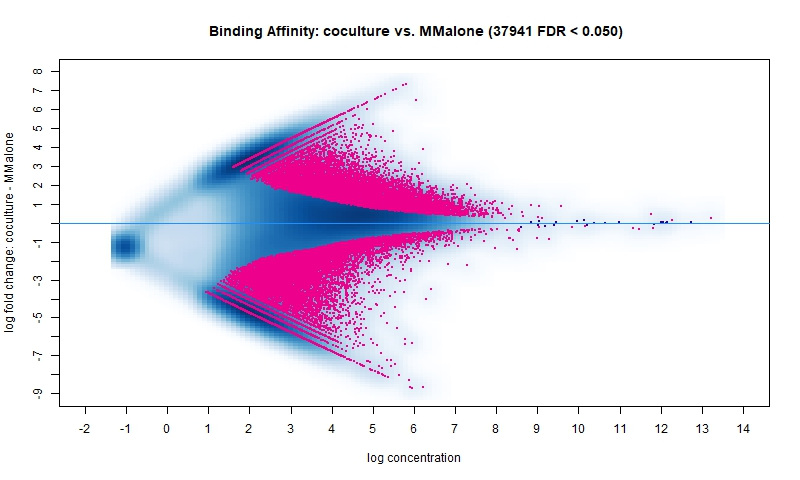

In [32]:
Image(filename='H3K27ac_MA.jpeg')

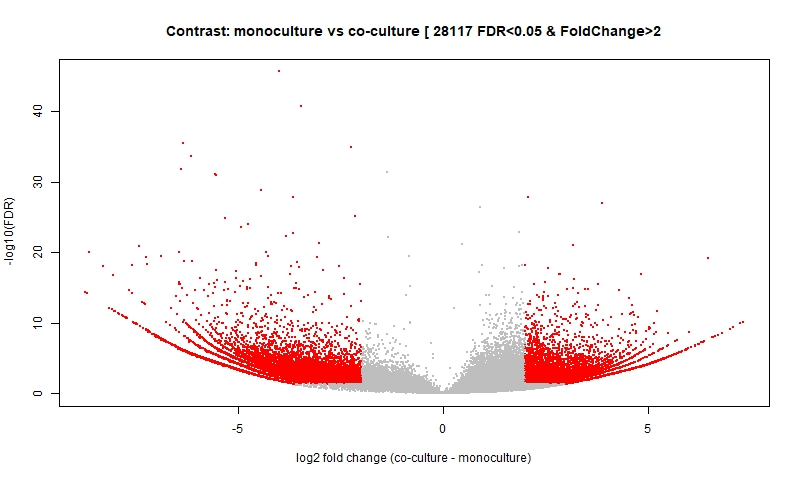

In [33]:
Image(filename='H3K27ac_volcano.jpeg')

### Differential binding site anotation and enrichment analysis

Here we use the online tool **GREAT** <http://great.stanford.edu/> to perform the analysis.

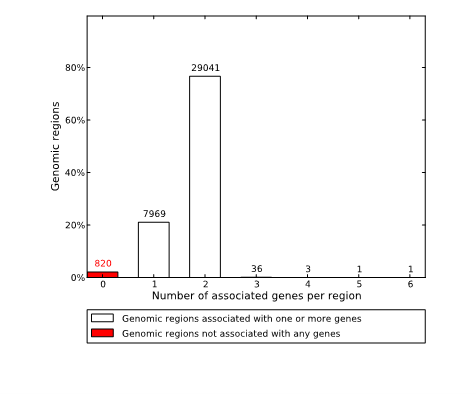

In [17]:
Image("H3K27ac_per.png")

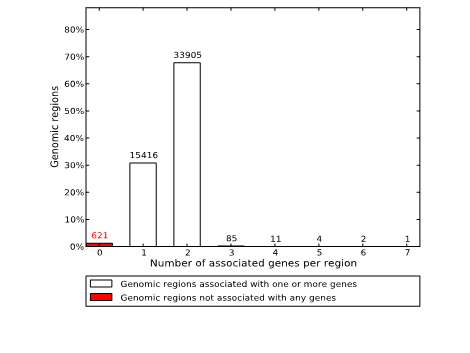

In [19]:
Image("H3K4me4_per.png")

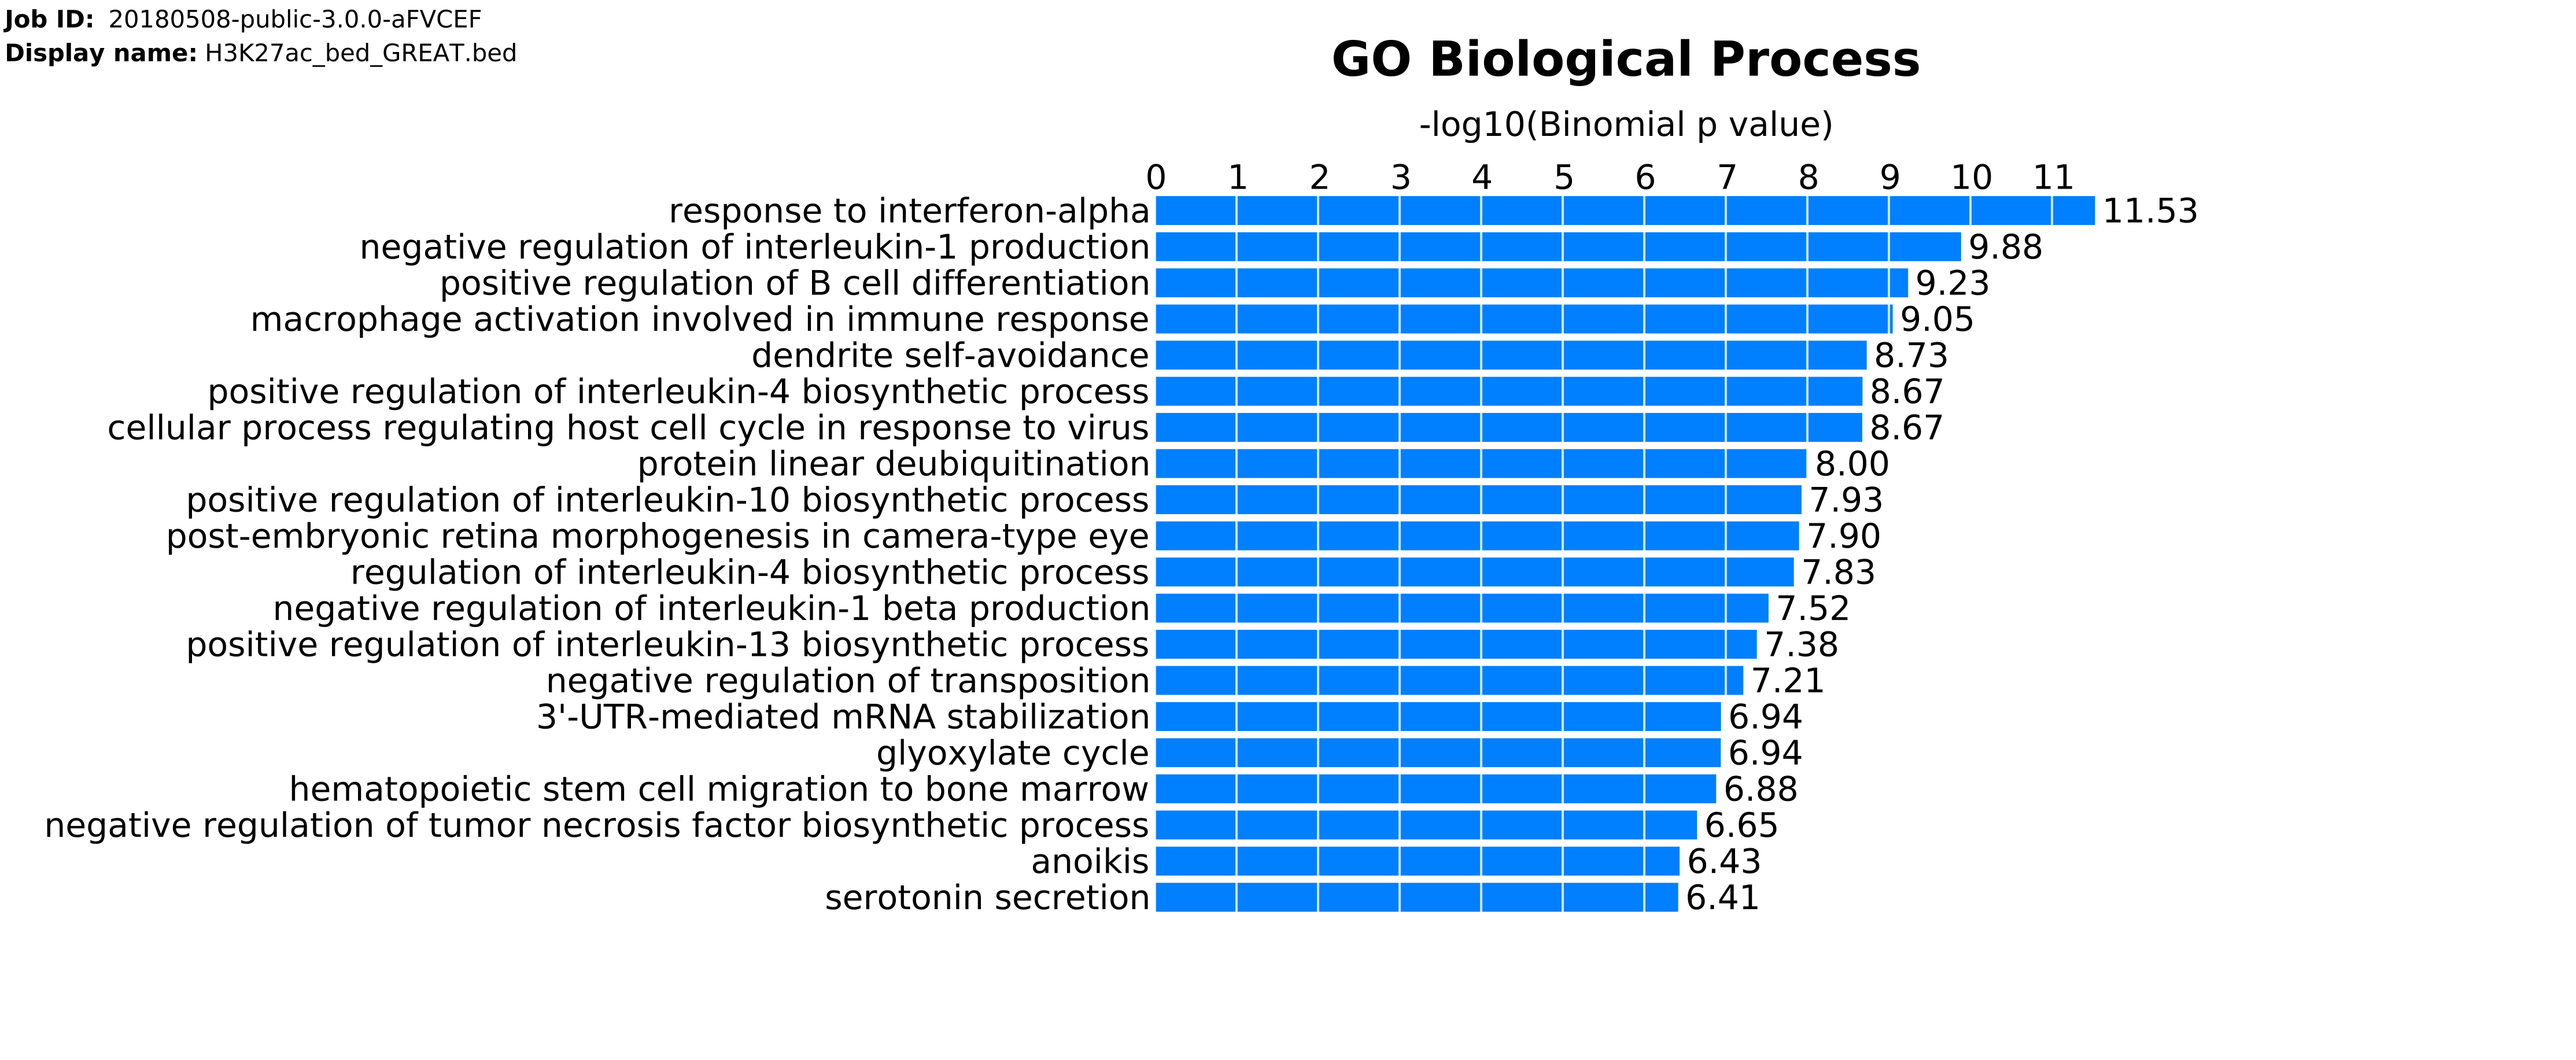

In [21]:
Image("H3K27ac_BP.png")

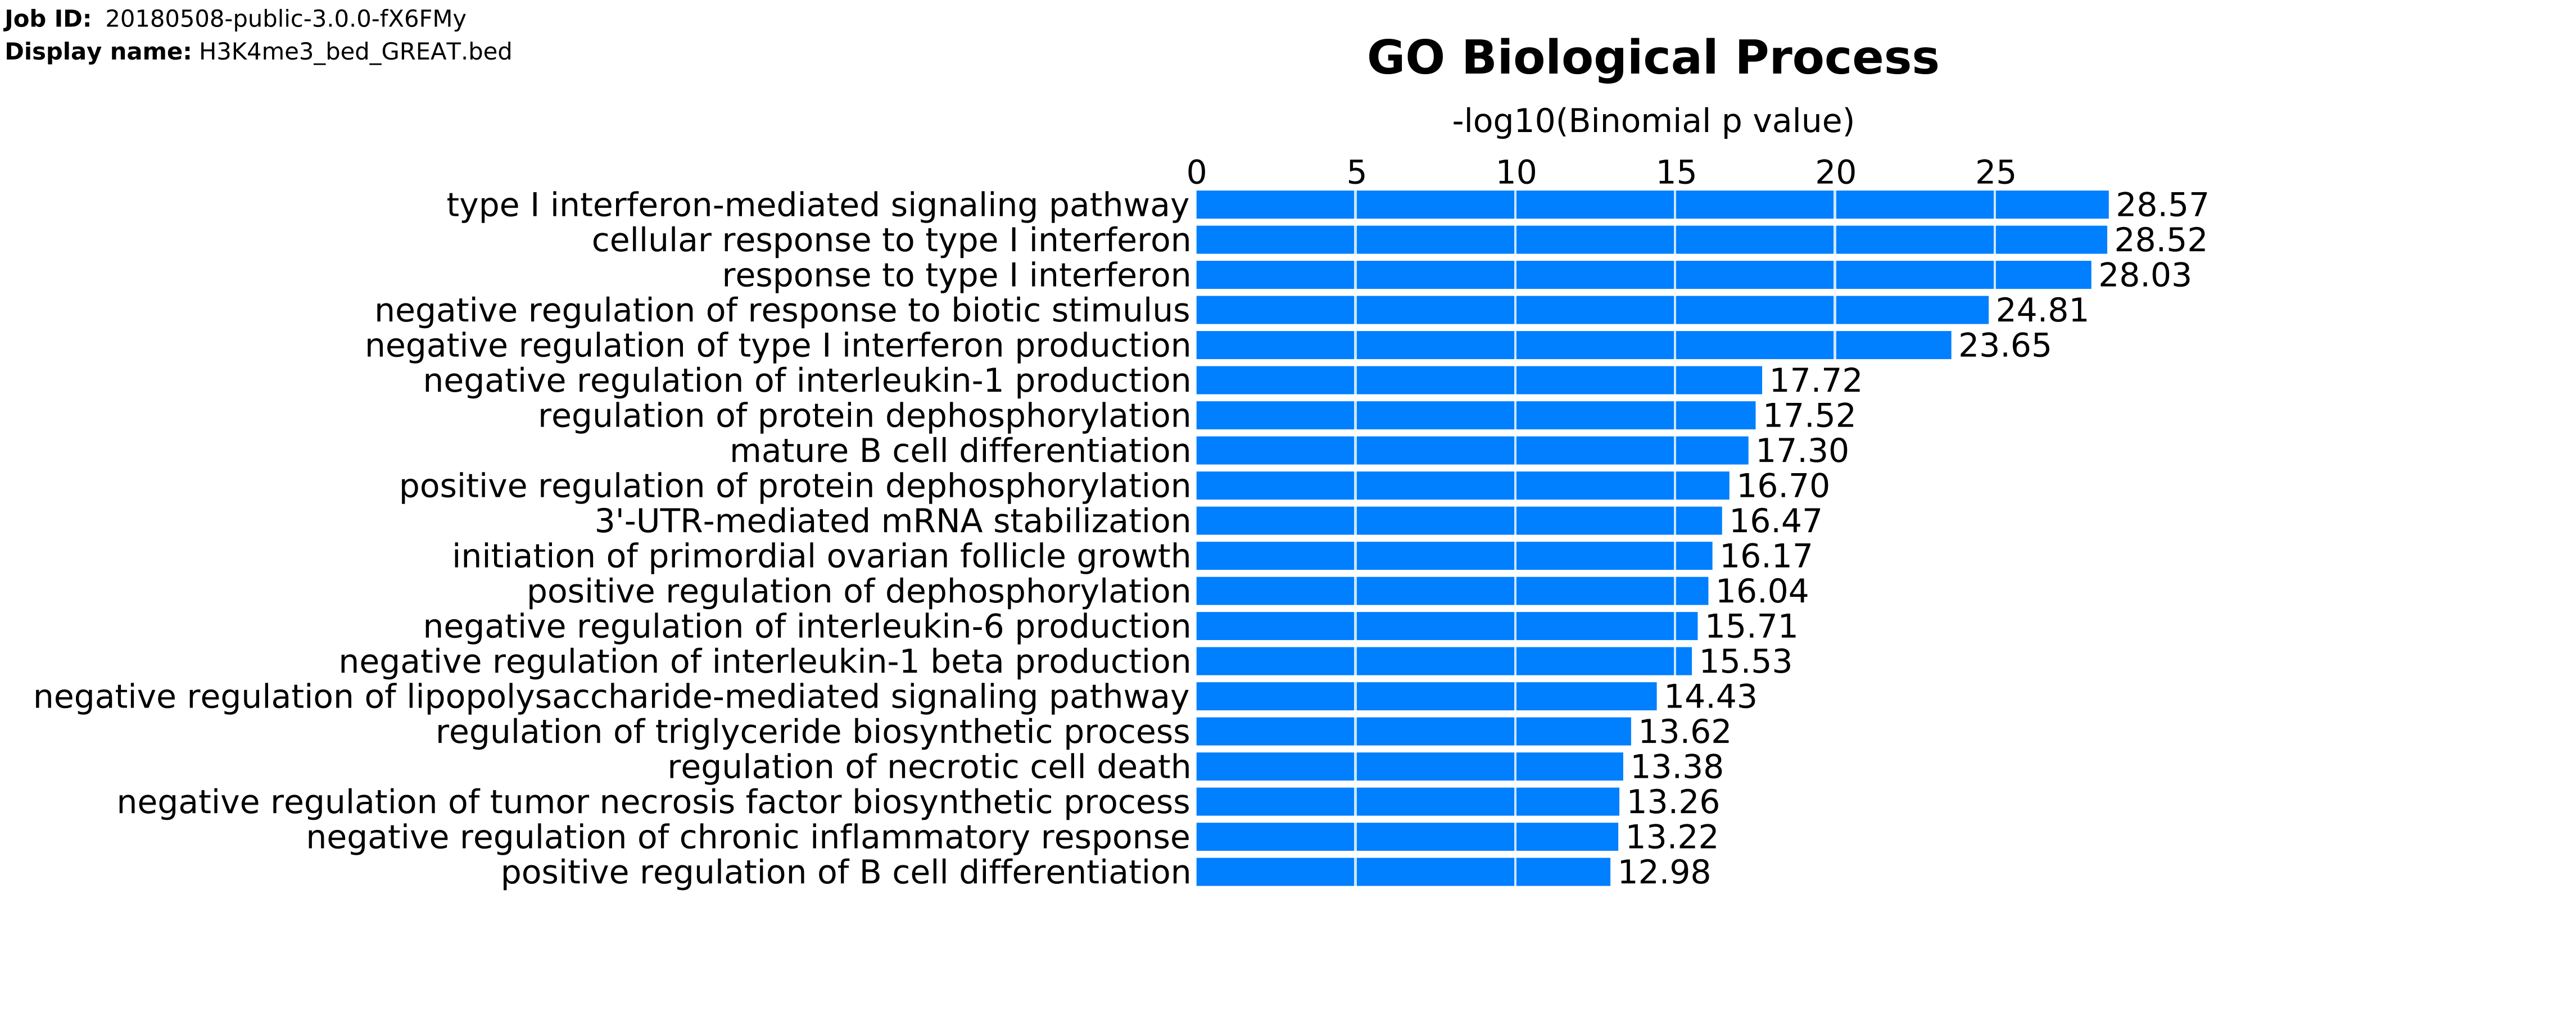

In [22]:
Image("H3K4me3_BP.png")

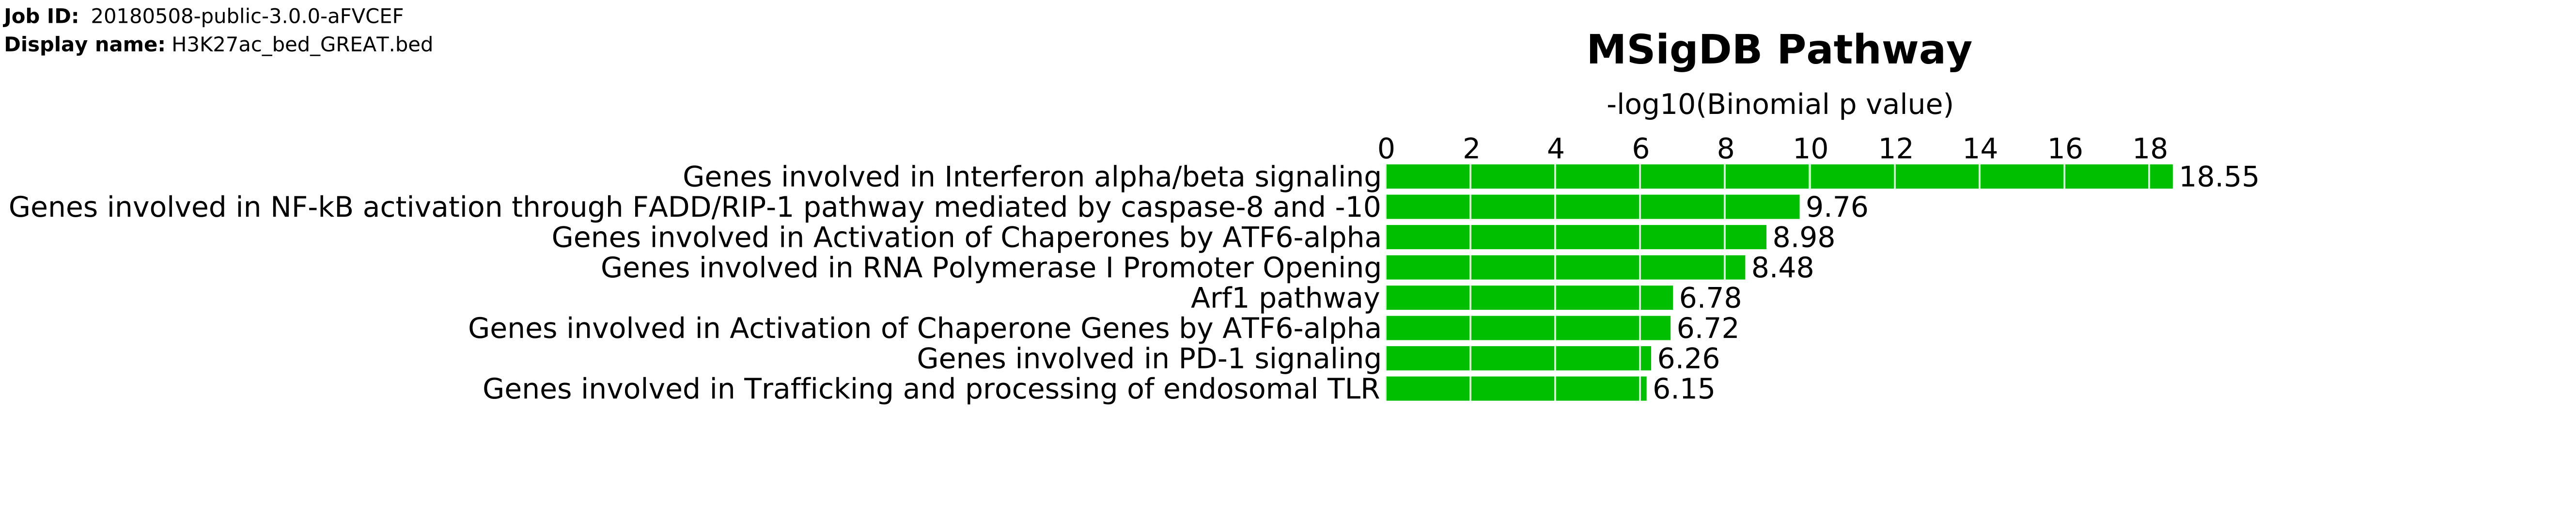

In [23]:
Image("H3K27ac_MSigDB.png")

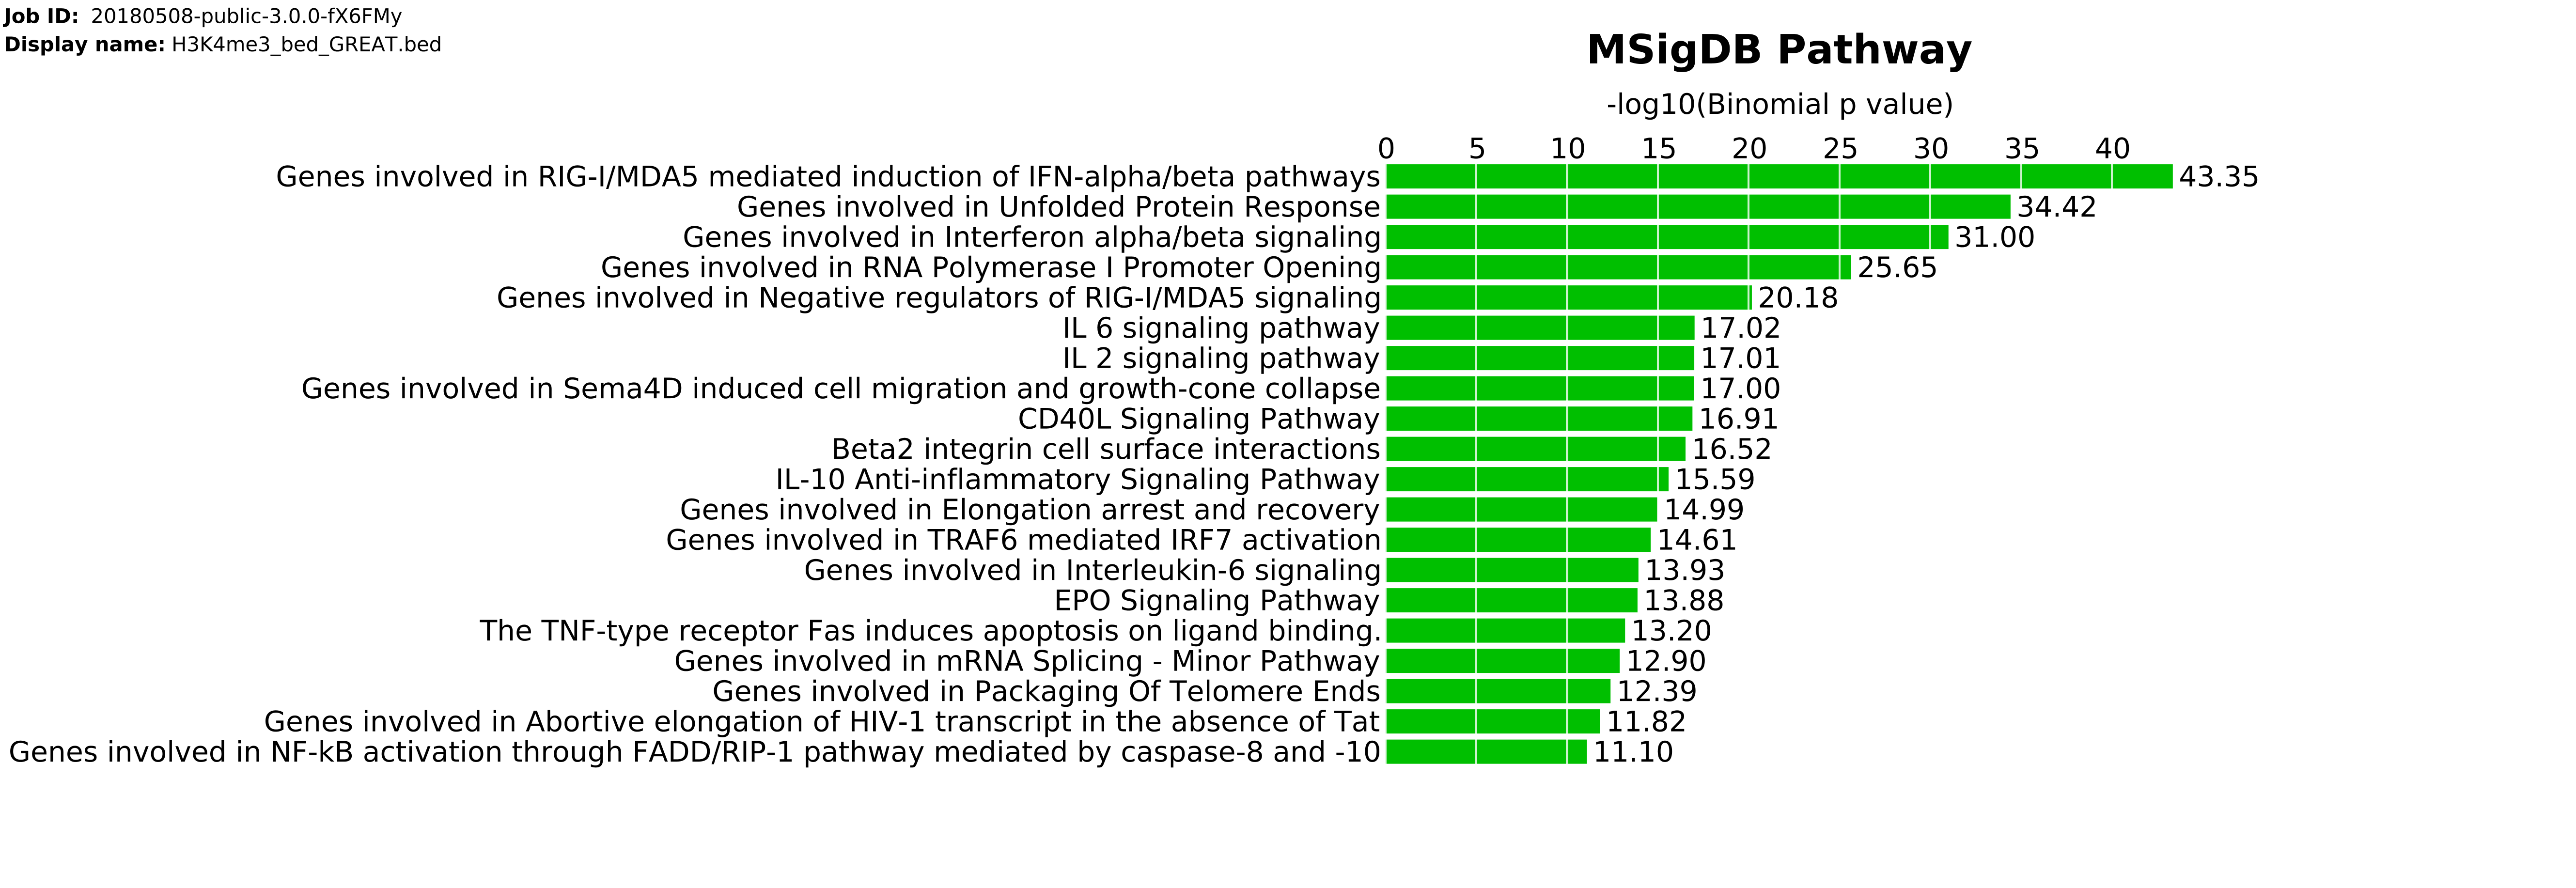

In [24]:
Image("H3K4me3_MSigDB.png")

### Motif Analysis

Use Homer to do Motif Analysis. Computation was done on clusters.

In [38]:
%%bash
sbatch homer.sh

-bash: line 1: sbatch: command not found


The codes are showed below.

In [39]:
highlight_source_bash("homer.sh")

The motif analysis results are showed below.

Result of H3K4me3 increasing binding sites

In [40]:
FileLink("./homer_output/H3K4me3_increase/knownResults.html")

C:\Users\songdongyuan\group02_final_project_packet\homer_output\H3K4me3_increase\knownResults.html

Result of H3K4me3 decreasing binding sites

In [41]:
FileLink("./homer_output/H3K4me3_decrease/knownResults.html")

C:\Users\songdongyuan\group02_final_project_packet\homer_output\H3K4me3_decrease\knownResults.html

Result of H3K27ac increasing binding sites

In [42]:
FileLink("./homer_output/H3K27ac_increase/knownResults.html")

C:\Users\songdongyuan\group02_final_project_packet\homer_output\H3K27ac_increase\knownResults.html

Result of H3K27ac
decreasing binding sites

In [43]:
FileLink("./homer_output/H3K27ac_decrease/knownResults.html")

C:\Users\songdongyuan\group02_final_project_packet\homer_output\H3K27ac_decrease\knownResults.html